In [1]:
## Quantum Teleportation experiment
## Andres Coronado - Luca Frontirre` 
## Unige - Assignment by prof. Solinas
import math
import qiskit as qk

from qiskit import IBMQ
from qiskit import ClassicalRegister, QuantumRegister, QuantumCircuit

#useful additional packages
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from math import pi

from qiskit.tools.visualization import circuit_drawer
 
#visualization
from qiskit.visualization import(
  plot_state_city,
  plot_bloch_multivector,
  plot_state_paulivec,
  plot_state_hinton,
  plot_state_qsphere,
)


IBMQ.save_account(open("token.txt").read())
IBMQ.load_account()

Credentials already present. Set overwrite=True to overwrite.


<AccountProvider for IBMQ(hub='ibm-q', group='open', project='main')>

$$\newcommand{\ket}[1]{\left|{#1}\right\rangle}$$
$$\newcommand{\bra}[1]{\left\langle{#1}\right|}$$
# Quantum teleportation

## Abstract
<hr>

Alice vuole inviare una informazione *quantistica* a Bob. <br>
Nello specifico supponiamo che Alice voglia di dover mandare uno stato generico<br>   
$$\ket{\psi} = \alpha \ket{0} + \beta \ket{1} $$ a Bob.

## Non si può semplicimente copiare
<hr>
Esiste un teorema nella meccanica quantistica conosciuto come "non cloning theorem" 
che ci dice che non si può smeplicemente copiare esattamente uno stato quantistico "sovrapposto" 
non misurato, perciò Alice non può inviare una copia del suo stato $\ket{\psi}$ e darla a Bob. 
Copiare uno stato è solo possibile con bit "tradizionali"

Ciò nonostante Alice può trasferire il suo stato a Bob senza copiaro ma attraverso un protocollo 
(un algoritmo distribuito) che qui chiamiamo " teletrasporto quantistico" poichè come risultato di
tale operazione Bob sarà in possesso dello stato $\ket{\psi}$ ed allo stesso tempo Alice lo perderà.

## Protocollo di teletrasporto quantistico
<hr>
il protocollo si compone di 4 passi:

### 1. Generare una coppia di bit Entangled
Si prende una coppia di qBit $q0$ e $q1$ i quali siano in uno stato entangled. Questa coppia di qBit 
è detta coppia di Bell poichè si ottiene in computazione quantistica applicando su uno dei qBit la porta 
H (la porta di Hadamard), il cui output porta tale qBit a trovarsi in uno stato svrapposto la cui probabiltà
di misurare $\ket{1}$ è la stessa di misurare $\ket{0}$ (base di Bell) e successivamente si applica una porta $CNOT$ 
all'altro qBit, controllata da quello nella base di Bell come illustrato nella seguente funzione: 
         

In [2]:
# Crea stato entangled tra 2 qbits 
def createBellEntangledState(qCircuit,aliceQBit,BobQbit):
    qCircuit.h(aliceQBit)
    qCircuit.cx(aliceQBit,BobQbit)
    return   

Ad esempio partendo $q0 = \ket{0}$ 
otteniamo $ \Rightarrow H|0>=\dfrac{\ket{0}+\ket{1}}{\sqrt{2}}$, 

successivamente applicando la porta $CNOT$ controllata da $q1$, 
abbiamo la garanzia che lo stato di $q1$ dipenda dallo stato di $q0$

- con $P=\dfrac{1}{\sqrt{2}^2} = \dfrac{1}{2}$ misurando $q0$ si leggerà $\ket{0}>$
- si leggerà quindi $|1>$ con altrettanta probabilità 

Di conseguenza supponendo $q1$ inizialmente a $\ket{0}$ dopo una misura risulterà 

- $\ket{0}$ se la misura in $q0$ fosse risultata $\ket{0}$
- $\ket{1}$ se la misura in $q0$ fosse risultata $\ket{1}$ 

Questo è quindi il significato di una coppia di qBit in questa conficurazione: 

*la misura del primo dei due qBit determina quello che sarà misurato nel secondo.*    

Per continuare supporremo quindi che
- *Alice possega $\ket{\psi}$*
- *Alice possegga q0*
- *Bob possegga q1*

#### Sulla costruzione dello stato $\ket{\psi}$ ...
<hr>
Per la generazione di uno stato arbitrario $\ket{\psi} = \alpha\ket{0}+\ket{1}$ usiamo il metodo **Initialize** messo a disposizione dal kit di sviluppo qiskit.
Definiamo quindi una funzione che avendo in input una probabilità $|\alpha|^2$  (ed un circuito quantistico) generi una porta quantistica che costruisca lo stato desiderato

Il metodo initialize appartenente alla classe Inizializer di qiskit per ottenere uno stato arbitrario costruisce un circuito ottimizzato e quindi meno soggetto ad errori.

Per Ottenere uno stato arbitrario in maniera "manuale" bisogna pensare alle componenti $\alpha$ e $\beta$ appartenenti allo stato $\ket{\psi}$.

Ricapitolando:

- $|\alpha|^2+|\beta|^2=1$ 
- La fase globale non è rilevabile cioè $\left|\psi\right\rangle := e^{i\delta} \left|\psi\right\rangle$
- Dopo una misura, la probabilità che il sistema sia in $\ket{0}$ è $|\alpha|^2$	
- Dopo una misura, la probabilità che il sistema sia in $\ket{1}$ è $|\beta|^2$

Ci bastano quindi solo due numeri reali $\alpha$ e $\beta$ a descrivere lo stato di un singolo qBit:


$$
\left|\psi\right\rangle = \cos(\theta/2)\left|0\right\rangle + \sin(\theta/2) e^{i\phi} \left|1\right\rangle \\
\text{dove: }\sin{\theta}^2 + \cos{\phi}^2 = 1
$$

Ne consegue che, come evidenziato vi è la possibilità di mappare tutti gli stati dei qbit ($\mathbb{C}^2$) 
sui punti della sfera unitaria, chiamata la sfera di Bloch.
Questo ci permette di stabilre che uno stato generico possa essere rappresentato da un vettore di lunghezza unitaria definito dai suoi due angoli
$\theta$ e $\psi$, mentre un operatore può essere quindi visto come una trasformazione (una rotazione su uno o sui due angoli).

<img src="bloch.png" height=10>

Ad esempio una porta unitaria $U_{\theta}$ che realizzi una rotazione può essere scritta: 

$$
U_{\theta}
\begin{bmatrix}
0 \\
1 
\end{bmatrix}	
= 
\begin{bmatrix}
cos{\theta} & sin{\theta} \\
sin{\theta} & -cos{\theta}
\end{bmatrix}
\begin{bmatrix}
0 \\
1 
\end{bmatrix}
$$

Questa porta risulta in una rotazione con segno opposto per $\ket{1}$, mentre di una normale rotazione per $\ket{0}$. 
Ci ad esempio sono dei casi notevoli:

- quando $\theta$ vale $0$ lo stato $\ket{0}$ rimane invariato mentre lo stato $\ket{1}$ ha segno opposto.
- quando $\theta$ vale $\dfrac{\pi}{4}$ $U_{\theta}$ si comporta come una porta di Hadamard-Walsh
- quando $\theta$ vale $\dfrac{\pi}{2}$ $U_{\theta}$ si comporta come una porta NOT.

Similmente possiamo pensare a porte che possano effettuare rotazioni arbitrarie (su un asse arbitrario) generalizzando possiamo ottenere uno stato 
arbitrario compiendo una rotazione dallo stato iniziale del qBit applicando una porta unitaria $U = e^{i\gamma}R_{\hat{n}(\alpha)}$ per una coppia 
di valori $\gamma$ e $\alpha$ e un vettore tridimensionale (asse) $\hat{n}$ che utilizzi le tre rotazioni $R_x$, $R_y$, $R_z$ ottenute esponenziando
le matrici $X$ $Y$ $Z$ di Pauli. ($R_x= e^{-i\dfrac{\theta}{2}X}$)
- Ad esempio $U$ con $ \gamma = \dfrac{\pi}{2}$, $\alpha=\pi$ e $\hat{n} =(\dfrac{1}{\sqrt{2}},0,\dfrac{1}{\sqrt{2}}) $ da origine a una porta $H$.

Una volta espresso un vettore $Q$ nella sfera di Bloch in termini di angoli possiamo quindi sempre trovare 
una rotazione che possa spostare il nostro vettore iniziale esattamente ad avere i valori da noi arbitrariamente scelti.


In [12]:
# funzione che inizializza uno stato quantistico arbitrario
# |psi> = sqrt(alpha)|0> + sqrt(1-alpha)|1>
def initializeQuantumState(p,qC):
    desired_vector = [
    
    math.sqrt(p) * complex(0, 1),
    math.sqrt(1-p) * complex(1, 0)
    
    ]
    
    qC.initialize(desired_vector,[0])
   
    
    #pretty print 
    print("Desired probabilities: ")
    
    print(str(
        list(
            map(
                lambda x: format(abs(x * x), '.3f'), desired_vector
            )
        )
    ))
    
    return

In [4]:
# circuit: circuito quantistico dove implementare il teletraasporto
# aliceFstQbit: stato psi da teletrasportare attraverso il protocollo
# aliceSndQbit: q0 appartenente ad Alice
# bobQbit: q1 appartenente a Bob

def deployTeleportProtocol(qCircuit, aliceFstQbit, aliceSndQbit, bobQbit, measureBits):
    createBellEntangledState(qCircuit,aliceSndQbit,bobQbit)
    
    #2. Alice applica una porta CNOT sul suo qBit controllata da psi
    qCircuit.cx(aliceFstQbit,aliceSndQbit)
    
    #3. Alice applica una porta H a psi 
    qCircuit.h(aliceFstQbit)   
    qCircuit.cx(aliceSndQbit,bobQbit)
    qCircuit.cz(aliceFstQbit,bobQbit)
    qCircuit.measure(aliceFstQbit, measureBits[0])
    qCircuit.measure(aliceSndQbit, measureBits[1])
    qCircuit.measure(bobQbit, measureBits[2])

In [5]:

def buildCircuit(modAlphaSquared):
    # contiene i qbit: due di Alice uno di Bob 
    q = QuantumRegister(3) 
    # per effettuare le misure
    c = ClassicalRegister(3)
    # contiene il programma che verra` eseguito
    qc = QuantumCircuit(q,c)
    initializeQuantumState(modAlphaSquared,qc)
    deployTeleportProtocol(qc,q[0],q[1],q[2],c)
    return qc




Desired probabilities: 
['0.900', '0.100']


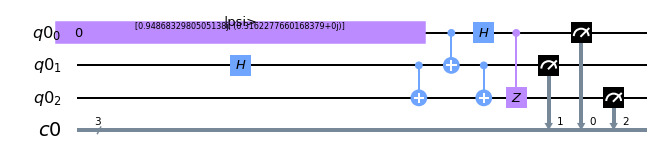

In [6]:
qc = buildCircuit(0.9)
qc.draw(output='mpl',scale=0.5)

Desired probabilities: 
['0.300', '0.700']


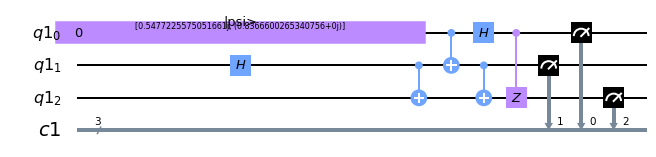

In [7]:
qc2 = buildCircuit(0.3)
qc2.draw(output='mpl',scale=0.5)

In [8]:
#printing out all the queues
provider = IBMQ.get_provider("ibm-q")

for backend in provider.backends():
    try:
        qubit_count =  len(backend.properties().qubits)
    except:
        qubit_count = "simulated"
        
    #Italian Front-End :-D
    print(f"[{backend.name()}] ha {backend.status().pending_jobs} lavori in coda e {qubit_count} qubits")

[ibmq_qasm_simulator] ha 1 lavori in coda e simulated qubits
[ibmqx2] ha 98 lavori in coda e 5 qubits
[ibmq_16_melbourne] ha 111 lavori in coda e 15 qubits
[ibmq_vigo] ha 1 lavori in coda e 5 qubits
[ibmq_ourense] ha 1 lavori in coda e 5 qubits
[ibmq_london] ha 21 lavori in coda e 5 qubits
[ibmq_burlington] ha 1 lavori in coda e 5 qubits
[ibmq_essex] ha 3 lavori in coda e 5 qubits
[ibmq_armonk] ha 3 lavori in coda e 1 qubits


In [9]:
#chose one backend (less queue the better... need to wait....)
from qiskit.tools.monitor import job_monitor
backend = provider.get_backend("ibmq_ourense")


job = qk.execute(qc, backend=backend, shots=1024)
job2 = qk.execute(qc2, backend=backend, shots=1024)

job_monitor(job)
job_monitor(job2)

Job Status: job has successfully run
Job Status: job has successfully run


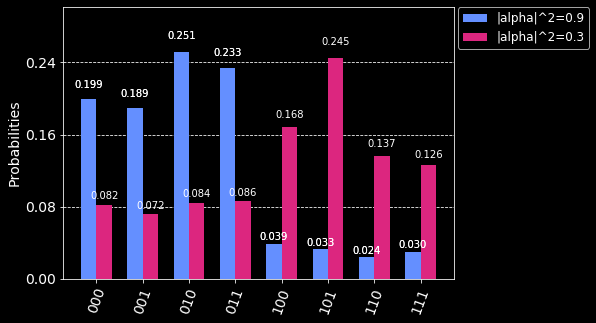

In [10]:
from qiskit.visualization import plot_histogram
from matplotlib import style

#dark background on jupyterLab...
style.use("dark_background")

# Plot results with legend
legend = ['|alpha|^2=0.9', '|alpha|^2=0.3']

result=job.result()
result2=job2.result()

counts = result.get_counts(qc)
counts2 = result2.get_counts(qc2)

plot_histogram([counts, counts2], legend=legend)
